# Random Forest Model

In [19]:
# === Section 1: Data Preprocessing & Model Training ===
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load and clean data
df = pd.read_csv("train.csv")
df.columns = df.columns.str.strip()

# Encode categorical features
encoders = {}
for column in df.select_dtypes(include='object').columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    encoders[column] = encoder

satisfaction_encoder = encoders['satisfaction']

# Define features and target
feature_columns = ['Age', 'Flight Distance', 'Seat comfort', 'Leg room service']
X = df[feature_columns]
y = df['satisfaction']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=satisfaction_encoder.classes_))


Classification Report:
                         precision    recall  f1-score   support

neutral or dissatisfied       0.75      0.78      0.76     11713
              satisfied       0.70      0.66      0.68      9068

               accuracy                           0.73     20781
              macro avg       0.72      0.72      0.72     20781
           weighted avg       0.73      0.73      0.73     20781



## Random Forest - Data Visualization

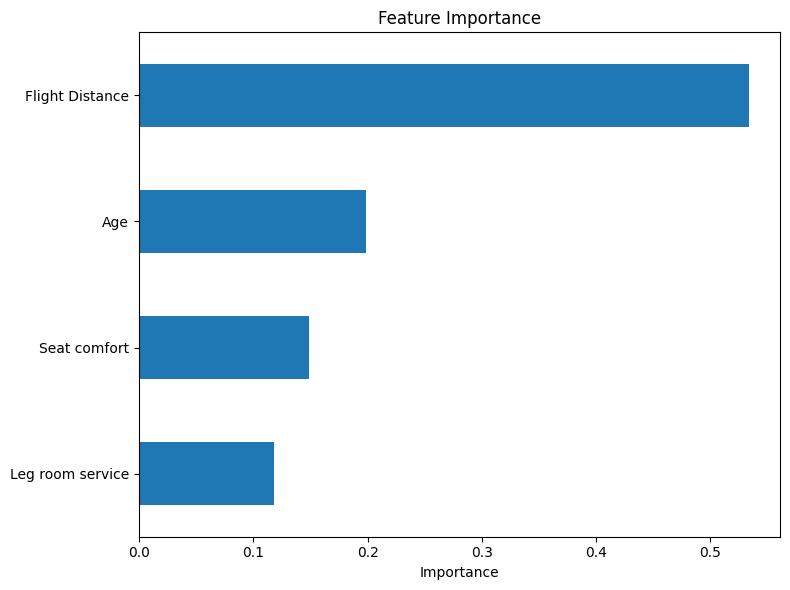

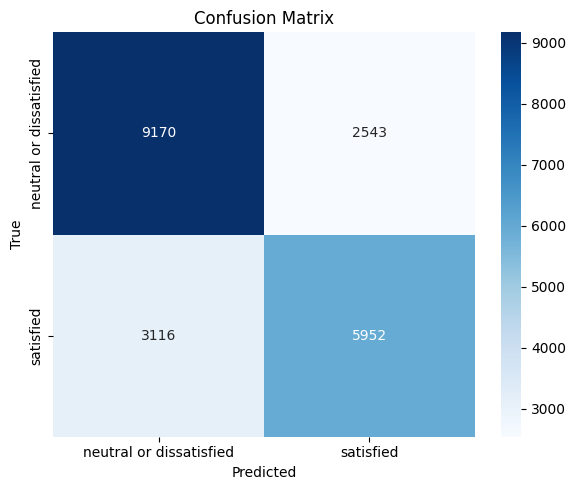

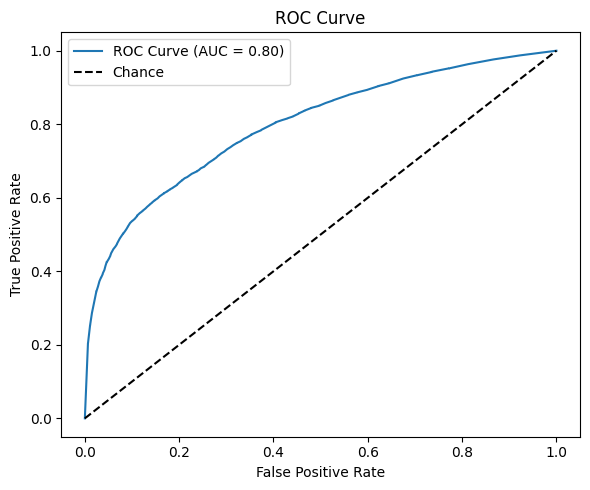

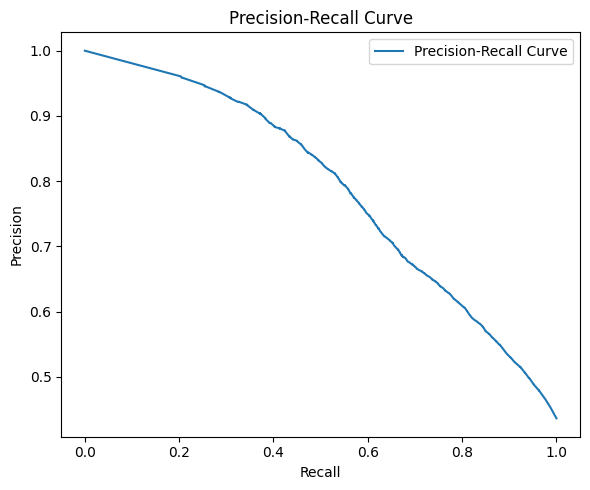

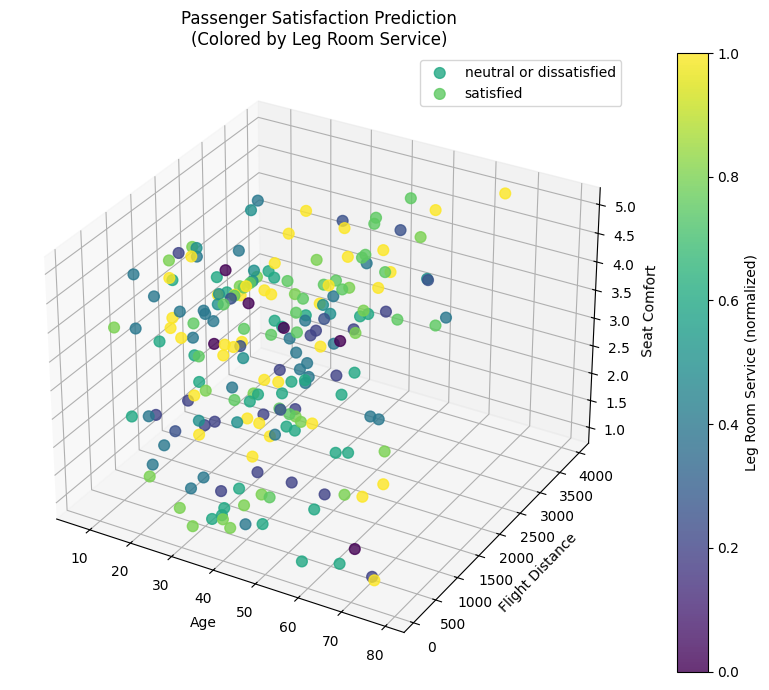

In [20]:
# === Section 2: Data Visualization & Model Evaluation ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 1. Feature Importance
plt.figure(figsize=(8, 6))
feature_importance = pd.Series(model.feature_importances_, index=feature_columns)
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=satisfaction_encoder.classes_,
            yticklabels=satisfaction_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

# 5. 3D Scatter Plot of Predictions
sample = df.sample(200).copy()
X_sample = sample[feature_columns]
sample['Predicted Satisfaction'] = model.predict(X_sample)
sample['Predicted Label'] = satisfaction_encoder.inverse_transform(sample['Predicted Satisfaction'])

# Normalize Leg Room Service for coloring
legroom_normalized = (sample['Leg room service'] - sample['Leg room service'].min()) / \
                     (sample['Leg room service'].max() - sample['Leg room service'].min())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each predicted class
for label in sample['Predicted Satisfaction'].unique():
    subset = sample[sample['Predicted Satisfaction'] == label]
    ax.scatter(
        subset['Age'],
        subset['Flight Distance'],
        subset['Seat comfort'],
        c=legroom_normalized[subset.index],
        cmap='viridis',
        s=60,
        alpha=0.8,
        label=satisfaction_encoder.inverse_transform([label])[0]
    )

ax.set_xlabel('Age')
ax.set_ylabel('Flight Distance')
ax.set_zlabel('Seat Comfort')
ax.set_title('Passenger Satisfaction Prediction\n(Colored by Leg Room Service)')
ax.legend()
plt.colorbar(ax.collections[0], label='Leg Room Service (normalized)')
plt.tight_layout()
plt.show()


In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

# 1. Feature Importance (Print Sorted List)
print("\n=== Feature Importance ===")
feature_importance = pd.Series(model.feature_importances_, index=feature_columns)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance.to_string())

# 2. Confusion Matrix
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=satisfaction_encoder.classes_, columns=satisfaction_encoder.classes_)
print(cm_df)

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=satisfaction_encoder.classes_))

# 3. ROC Curve (Print AUC and points)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\n=== ROC Curve ===\nAUC: {roc_auc:.4f}")
print("Sample Points (FPR, TPR):")
for i in range(0, len(fpr), max(1, len(fpr) // 10)):
    print(f"({fpr[i]:.2f}, {tpr[i]:.2f})")

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
print("\n=== Precision-Recall Curve ===")
print("Sample Points (Recall, Precision):")
for i in range(0, len(precision), max(1, len(precision) // 10)):
    print(f"({recall[i]:.2f}, {precision[i]:.2f})")

# 5. 3D Prediction Summary Table (Sample)
sample = df.sample(10).copy()  # smaller for terminal readability
X_sample = sample[feature_columns]
sample['Predicted Satisfaction'] = model.predict(X_sample)
sample['Predicted Label'] = satisfaction_encoder.inverse_transform(sample['Predicted Satisfaction'])

print("\n=== Sample Predictions ===")
print(sample[['Age', 'Flight Distance', 'Seat comfort', 'Leg room service', 'Predicted Label']])



=== Feature Importance ===
Flight Distance     0.534131
Age                 0.199014
Seat comfort        0.148906
Leg room service    0.117950

=== Confusion Matrix ===
                         neutral or dissatisfied  satisfied
neutral or dissatisfied                     9395       2318
satisfied                                   3169       5899

=== Classification Report ===
                         precision    recall  f1-score   support

neutral or dissatisfied       0.75      0.80      0.77     11713
              satisfied       0.72      0.65      0.68      9068

               accuracy                           0.74     20781
              macro avg       0.73      0.73      0.73     20781
           weighted avg       0.73      0.74      0.73     20781


=== ROC Curve ===
AUC: 0.7915
Sample Points (FPR, TPR):
(0.00, 0.00)
(0.04, 0.37)
(0.09, 0.49)
(0.14, 0.59)
(0.21, 0.67)
(0.30, 0.73)
(0.41, 0.79)
(0.52, 0.85)
(0.65, 0.90)
(0.80, 0.95)
(1.00, 1.00)

=== Precision-Recall Curv

# Logistic Regression

In [21]:
# === Section 1: Logistic Regression Model Training ===
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv("train.csv")
df.columns = df.columns.str.strip()  # Clean column names

# Encode categorical columns
encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Save encoder for decoding predictions
satisfaction_encoder = encoders['satisfaction']

# Corrected feature names (match with earlier Random Forest version)
features = ['Age', 'Flight Distance', 'Seat comfort', 'Leg room service']
X = df[features]
y = df['satisfaction']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Predictions
y_pred = logreg_model.predict(X_test)

# Evaluation
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred, target_names=satisfaction_encoder.classes_))


Logistic Regression - Classification Report:
                         precision    recall  f1-score   support

neutral or dissatisfied       0.75      0.80      0.77     11713
              satisfied       0.72      0.65      0.68      9068

               accuracy                           0.74     20781
              macro avg       0.73      0.73      0.73     20781
           weighted avg       0.73      0.74      0.73     20781



## Logistic Regression - Data Visualization

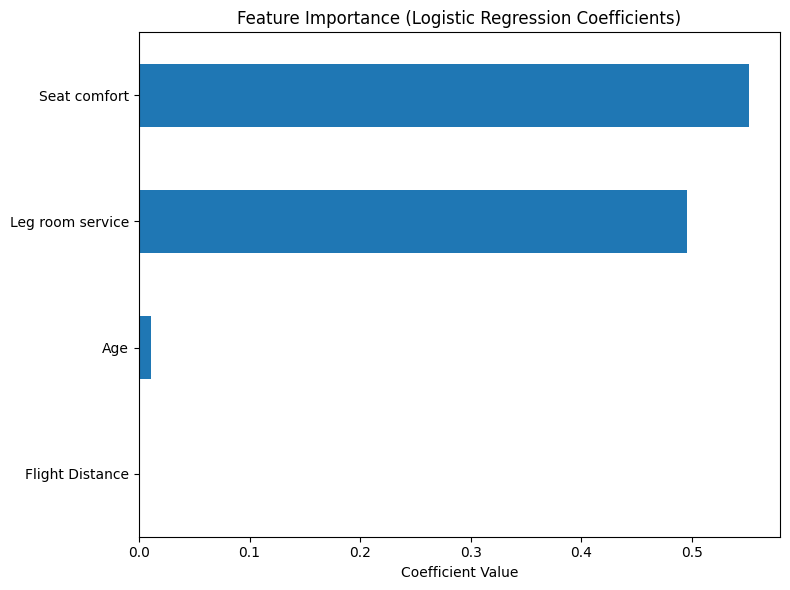

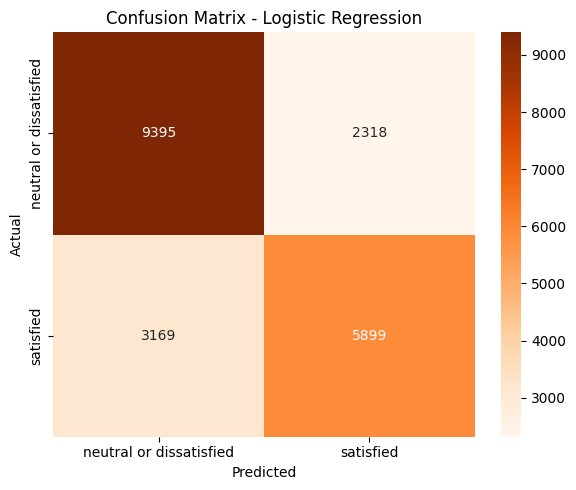

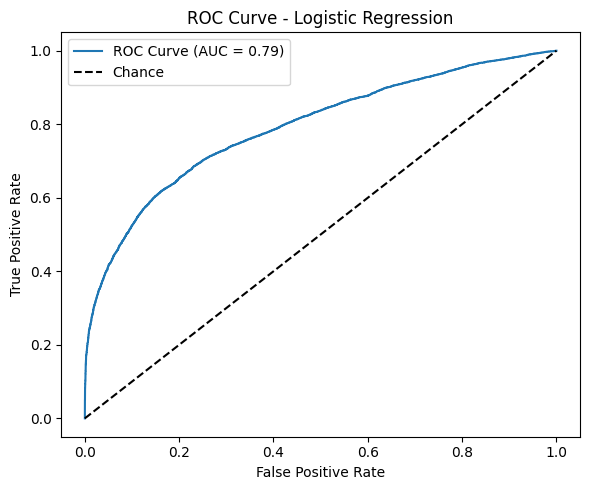

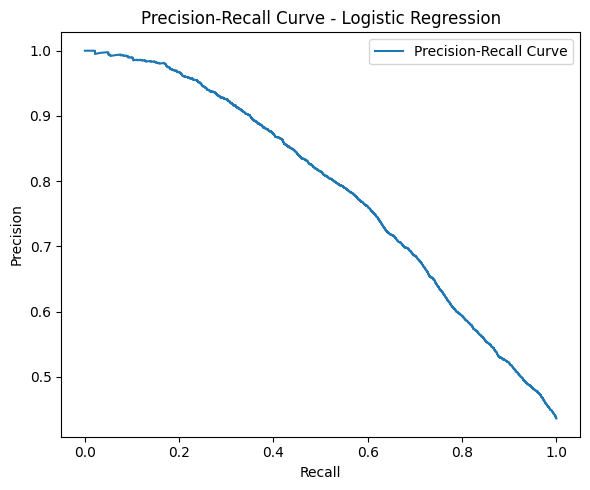

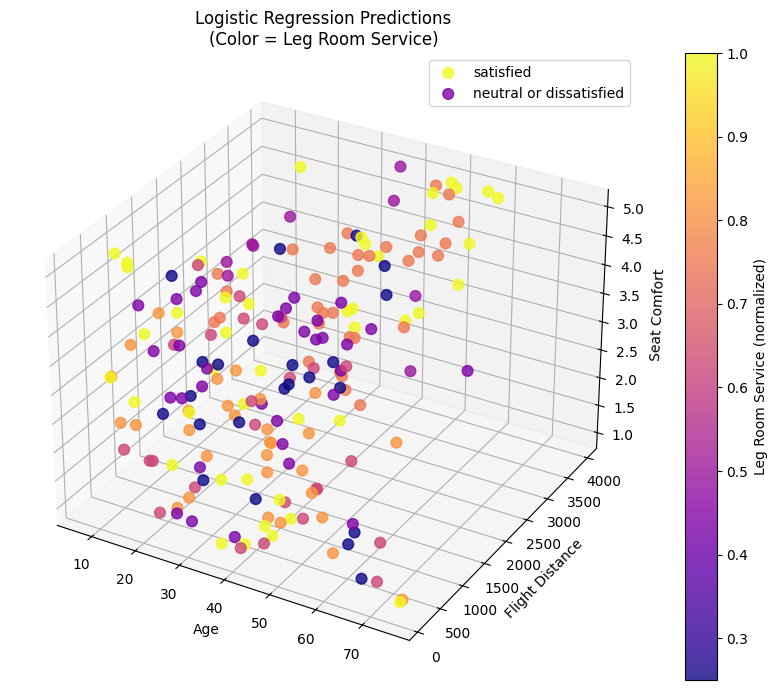

In [22]:
# === Section 2: Data Visualization (Logistic Regression) ===
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)
import numpy as np

# --- 1. Feature Importance (via model coefficients) ---
coefficients = pd.Series(logreg_model.coef_[0], index=features)
plt.figure(figsize=(8, 6))
coefficients.sort_values().plot(kind='barh')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

# --- 2. Confusion Matrix (Heatmap) ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=satisfaction_encoder.classes_,
            yticklabels=satisfaction_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

# --- 3. ROC Curve ---
# LogisticRegression's predict_proba gives probabilities for both classes
y_proba = logreg_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. 3D Scatter Plot of Predictions ---
# Take a random sample
sample = df.sample(200).copy()
X_sample = sample[features]
sample['Predicted Satisfaction'] = logreg_model.predict(X_sample)
sample['Predicted Label'] = satisfaction_encoder.inverse_transform(sample['Predicted Satisfaction'])

# Normalize Leg Room Service for coloring
legroom_normalized = (sample['Leg room service'] - sample['Leg room service'].min()) / \
                     (sample['Leg room service'].max() - sample['Leg room service'].min())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for label in sample['Predicted Satisfaction'].unique():
    subset = sample[sample['Predicted Satisfaction'] == label]
    ax.scatter(
        subset['Age'],
        subset['Flight Distance'],
        subset['Seat comfort'],
        c=legroom_normalized[subset.index],
        cmap='plasma',
        s=60,
        alpha=0.8,
        label=satisfaction_encoder.inverse_transform([label])[0]
    )

ax.set_xlabel('Age')
ax.set_ylabel('Flight Distance')
ax.set_zlabel('Seat Comfort')
ax.set_title('Logistic Regression Predictions\n(Color = Leg Room Service)')
ax.legend()
plt.colorbar(ax.collections[0], label='Leg Room Service (normalized)')
plt.tight_layout()
plt.show()


In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

# === 1. Feature Importance via Coefficients ===
print("\n=== Logistic Regression Feature Importance (Coefficients) ===")
coefficients = pd.Series(logreg_model.coef_[0], index=features)
coefficients = coefficients.sort_values(ascending=False)
print(coefficients.to_string())

# === 2. Confusion Matrix ===
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=satisfaction_encoder.classes_, columns=satisfaction_encoder.classes_)
print(cm_df)

# Classification Report (Precision, Recall, F1-score)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=satisfaction_encoder.classes_))

# === 3. ROC Curve and AUC ===
y_proba = logreg_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"\n=== ROC Curve ===\nAUC: {roc_auc:.4f}")
print("Sample Points (FPR, TPR):")
for i in range(0, len(fpr), max(1, len(fpr) // 10)):
    print(f"({fpr[i]:.2f}, {tpr[i]:.2f})")

# === 4. Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test, y_proba)
print("\n=== Precision-Recall Curve ===")
print("Sample Points (Recall, Precision):")
for i in range(0, len(precision), max(1, len(precision) // 10)):
    print(f"({recall[i]:.2f}, {precision[i]:.2f})")

# === 5. 3D Prediction Summary Table ===
sample = df.sample(10).copy()  # small sample for terminal
X_sample = sample[features]
sample['Predicted Satisfaction'] = logreg_model.predict(X_sample)
sample['Predicted Label'] = satisfaction_encoder.inverse_transform(sample['Predicted Satisfaction'])

print("\n=== Sample Predictions ===")
print(sample[['Age', 'Flight Distance', 'Seat comfort', 'Leg room service', 'Predicted Label']])



=== Logistic Regression Feature Importance (Coefficients) ===
Seat comfort        0.552233
Leg room service    0.495742
Age                 0.010579
Flight Distance     0.000551

=== Confusion Matrix ===
                         neutral or dissatisfied  satisfied
neutral or dissatisfied                     9395       2318
satisfied                                   3169       5899

=== Classification Report ===
                         precision    recall  f1-score   support

neutral or dissatisfied       0.75      0.80      0.77     11713
              satisfied       0.72      0.65      0.68      9068

               accuracy                           0.74     20781
              macro avg       0.73      0.73      0.73     20781
           weighted avg       0.73      0.74      0.73     20781


=== ROC Curve ===
AUC: 0.7915
Sample Points (FPR, TPR):
(0.00, 0.00)
(0.04, 0.37)
(0.09, 0.49)
(0.14, 0.59)
(0.21, 0.67)
(0.30, 0.73)
(0.41, 0.79)
(0.52, 0.85)
(0.65, 0.90)
(0.80, 0.95)
(1.0

# Linear Support Vector Machines (SVM)


In [28]:
# === Section 1: LinearSVC Model Training ===
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

# Load and clean dataset
df = pd.read_csv("train.csv")
df.columns = df.columns.str.strip()

# Encode categorical columns
encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

satisfaction_encoder = encoders['satisfaction']

# Use standardized feature names
features = ['Age', 'Flight Distance', 'Seat comfort', 'Leg room service']
X = df[features]
y = df['satisfaction']

# Feature scaling for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train Linear SVM
svm_model = LinearSVC(max_iter=10000)
svm_model.fit(X_train, y_train)

# Predict
y_pred = svm_model.predict(X_test)

# Evaluation
print("Linear SVM (LinearSVC) - Classification Report:")
print(classification_report(y_test, y_pred, target_names=satisfaction_encoder.classes_))


Linear SVM (LinearSVC) - Classification Report:
                         precision    recall  f1-score   support

neutral or dissatisfied       0.75      0.80      0.77     11713
              satisfied       0.72      0.65      0.68      9068

               accuracy                           0.74     20781
              macro avg       0.73      0.73      0.73     20781
           weighted avg       0.73      0.74      0.73     20781



##  Linear Support Vector Machines (SVM) - Data Visualization


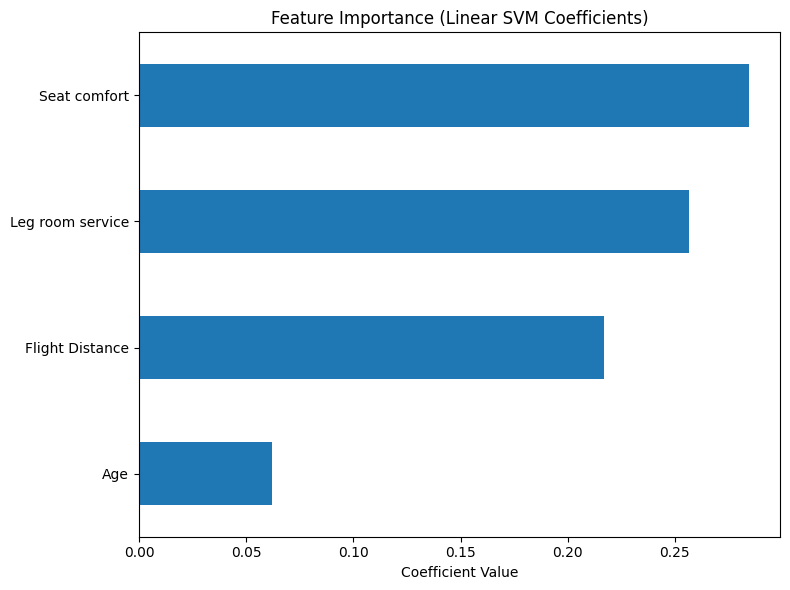

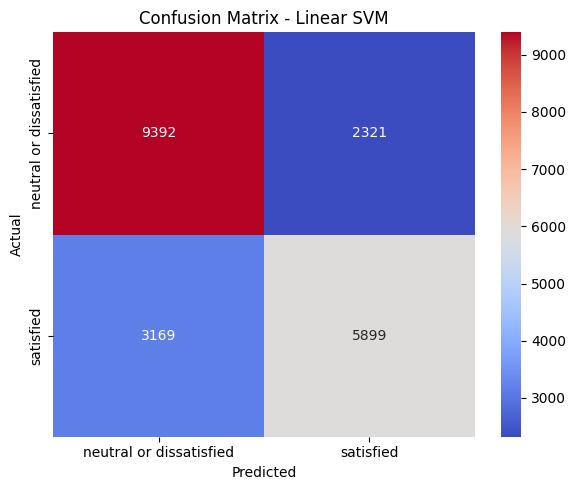

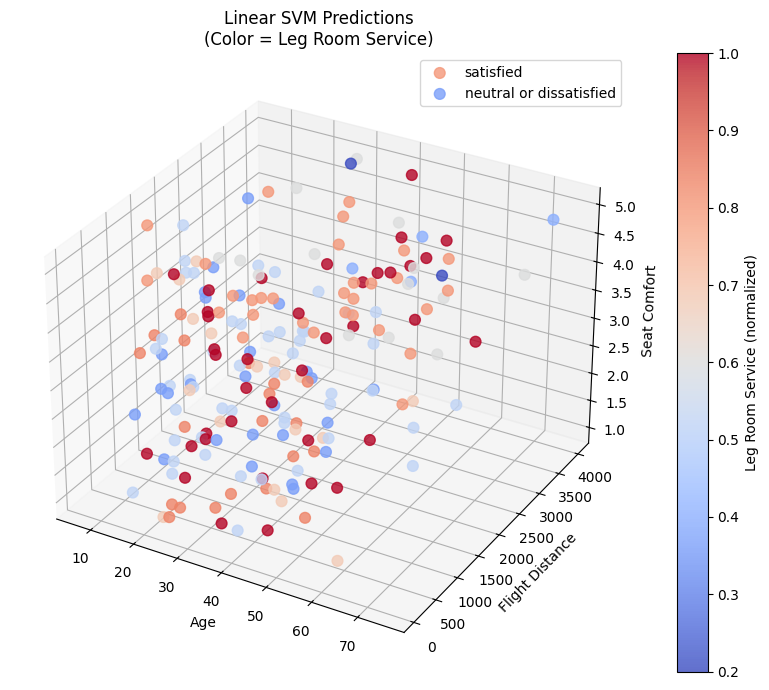

In [29]:
# === Section 2: Data Visualization (LinearSVC) ===
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
import numpy as np

# 1. Feature Importance (from coefficients)
coefficients = pd.Series(svm_model.coef_[0], index=features)
plt.figure(figsize=(8, 6))
coefficients.sort_values().plot(kind='barh')
plt.title("Feature Importance (Linear SVM Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=satisfaction_encoder.classes_,
            yticklabels=satisfaction_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear SVM")
plt.tight_layout()
plt.show()

# 3. 3D Scatter Plot of Predictions
# Sample for visualization
sample = df.sample(200, random_state=42).copy()
X_sample = scaler.transform(sample[features])  # Scale sample
sample['Predicted Satisfaction'] = svm_model.predict(X_sample)
sample['Predicted Label'] = satisfaction_encoder.inverse_transform(sample['Predicted Satisfaction'])

# Normalize Leg room service for coloring
legroom_norm = (sample['Leg room service'] - sample['Leg room service'].min()) / \
               (sample['Leg room service'].max() - sample['Leg room service'].min())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for label in sample['Predicted Satisfaction'].unique():
    subset = sample[sample['Predicted Satisfaction'] == label]
    ax.scatter(
        subset['Age'],
        subset['Flight Distance'],
        subset['Seat comfort'],
        c=legroom_norm[subset.index],
        cmap='coolwarm',
        s=60,
        alpha=0.8,
        label=satisfaction_encoder.inverse_transform([label])[0]
    )

ax.set_xlabel('Age')
ax.set_ylabel('Flight Distance')
ax.set_zlabel('Seat Comfort')
ax.set_title('Linear SVM Predictions\n(Color = Leg Room Service)')
ax.legend()
plt.colorbar(ax.collections[0], label='Leg Room Service (normalized)')
plt.tight_layout()
plt.show()


In [31]:
# === Section 2: Terminal Text-Based Visualization (LinearSVC) ===
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

print("\n=== Feature Importance (Linear SVM Coefficients) ===")
coefficients = pd.Series(svm_model.coef_[0], index=features)
coeff_sorted = coefficients.sort_values(ascending=False)
print(coeff_sorted.to_string())

# Explanation
print("\n💡 Explanation: Higher positive coefficients indicate features pushing toward 'satisfied'.")
print("   'Seat comfort' and 'Leg room service' are the strongest positive indicators.\n")

# Confusion Matrix
print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
labels = satisfaction_encoder.classes_
cm_df = pd.DataFrame(cm, index=[f"Actual: {l}" for l in labels],
                         columns=[f"Predicted: {l}" for l in labels])
print(cm_df)

# Explanation
print("\n💡 Explanation: The model performs slightly better on predicting 'neutral or dissatisfied'.")
print("   Higher diagonal values indicate correct predictions.\n")

# Classification Report
print("\n=== Classification Report ===")
report = classification_report(y_test, y_pred, target_names=labels)
print(report)

# Explanation
print("💡 Explanation: Accuracy is around 73%.")
print("   F1-score is slightly better for 'neutral or dissatisfied',")
print("   indicating slightly more reliable performance on the negative class.\n")

# 3D Scatter Plot Summary (Text-Based Insight)
print("\n=== 3D Scatter Plot Summary (Text Insight) ===")
sample = df.sample(10, random_state=42).copy()
X_sample = scaler.transform(sample[features])
sample['Predicted Satisfaction'] = svm_model.predict(X_sample)
sample['Predicted Label'] = satisfaction_encoder.inverse_transform(sample['Predicted Satisfaction'])

# Normalize Leg room service for display purposes
legroom_norm = (sample['Leg room service'] - sample['Leg room service'].min()) / \
               (sample['Leg room service'].max() - sample['Leg room service'].min())

print(sample[['Age', 'Flight Distance', 'Seat comfort', 'Leg room service', 'Predicted Label']].to_string(index=False))

print("\n💡 Explanation:")
print("   - Passengers with higher seat and leg room ratings tend to be predicted as 'satisfied'.")
print("   - Longer flights with low comfort ratings are usually predicted as 'neutral or dissatisfied'.")



=== Feature Importance (Linear SVM Coefficients) ===
Seat comfort        0.284788
Leg room service    0.256678
Flight Distance     0.216896
Age                 0.061917

💡 Explanation: Higher positive coefficients indicate features pushing toward 'satisfied'.
   'Seat comfort' and 'Leg room service' are the strongest positive indicators.


=== Confusion Matrix ===
                                 Predicted: neutral or dissatisfied  \
Actual: neutral or dissatisfied                                9392   
Actual: satisfied                                              3169   

                                 Predicted: satisfied  
Actual: neutral or dissatisfied                  2321  
Actual: satisfied                                5899  

💡 Explanation: The model performs slightly better on predicting 'neutral or dissatisfied'.
   Higher diagonal values indicate correct predictions.


=== Classification Report ===
                         precision    recall  f1-score   support

neut